# Accessing data later, after the measurement

From *2021-03 APS Python Training for Bluesky Data Acquisition*.

**Objective**

Get the data from previous *run(s)* and work with it.

## Skip the `instrument` package

There is no need to import the instrument package since we won't measure anything in this notebook.

## Access the database

In the instrument package (in file `instrument/framework/initialize.py`), we connected databroker with the MongoDB server using the `class_2021_03` *catalog*. Get that catalog now.  We'll need to import some tools first.

In [1]:
from apstools.utils import listruns
import databroker

db = databroker.catalog["class_2021_03"]
listruns()

catalog name: class_2021_03
========= ========================== ======= ======= ========================================
short_uid date/time                  exit    scan_id command                                 
========= ========================== ======= ======= ========================================
d59bc60   2021-02-24 13:10:43.853904 success 277     count(detectors=['temperature'], num=50)
5415661   2021-02-24 13:10:22.802185 success 276     count(detectors=['temperature'], num=10)
b8a414f   2021-02-24 13:10:21.182143 success 275     count(detectors=['temperature'], num=10)
88e1ce3   2021-02-24 13:10:20.306717 success 274     count(detectors=['temperature'], num=1) 
e6dd6e4   2021-02-24 12:56:55.782260 success 273     rel_scan(detectors=['noisy'], num=21 ...
75b515e   2021-02-24 12:56:53.767022 success 272     rel_scan(detectors=['noisy'], num=21 ...
8d5e91b   2021-02-24 12:56:09.239826 success 271     rel_scan(detectors=['noisy'], num=21 ...
aaffb17   2021-02-24 12:55:59.46

Our temperature count measurement is one of those listed, but which one?  Recall how we started our run: `RE(bp.count([temperature], num=50, delay=0.1, md={"motive": "tscan"}))`.  Let's look at the metadata of the most recent run:

In [29]:
from apstools.utils import quantify_md_key_use
from databroker.queries import TimeRange

# db.v2.search({"motive":"tscan"})
# db.v2.search(TimeRange(since="2020"))
# type(db.v2)
import databroker, intake
databroker.__version__, intake.__version__
# expecting 1.2.0, 0.6.0

('1.1.0', '0.6.0')

In [2]:
run = db.v2[-1]
run.metadata

{'start': Start({'beamline_id': 'APS_Python_training_2021',
 'detectors': ['temperature'],
 'hints': {'dimensions': [[['time'], 'primary']]},
 'instrument_name': 'class_2021_03',
 'login_id': 'mintadmin@mint-vm',
 'motive': 'tscan',
 'num_intervals': 49,
 'num_points': 50,
 'pid': 50241,
 'plan_args': {'detectors': ["MyPvPositioner(prefix='gp:userCalc8', "
                             "name='temperature', settle_time=0.0, "
                             "timeout=None, read_attrs=['setpoint', "
                             "'readback', 'done', 'calculation', "
                             "'description', 'max_change', 'noise', "
                             "'previous_value_pv', 'scanning_rate', "
                             "'tolerance'], configuration_attrs=[], "
                             "limits=(-20, 255), egu='C')"],
               'num': 50},
 'plan_name': 'count',
 'plan_type': 'generator',
 'proposal_id': 'training',
 'scan_id': 277,
 'time': 1614193843.8539045,
 'uid': 'd59b

## Get the data (from the database)
Let's get the measured data from the database now.  It's the most recent bluesky run, so an index of `-1` will identify it.

In [3]:
dataset = db.v2[-1].primary.read()

Let's get the values as a 1-D numpy array.

In [4]:
T = dataset["temperature_readback"].values

## Compute the statistics
Use the methods of numpy arrays to compute maximum, mean, standard deviation, and minimum.  Looks nicer in a table.

In [6]:
import pyRestTable

table = pyRestTable.Table()
table.addLabel("measure")
table.addLabel("value")
table.addRow(("max", T.max()))
table.addRow(("mean", T.mean()))
table.addRow(("dev", T.std()))
table.addRow(("min", T.min()))
table.addRow(("#", len(T)))
print(table)

======= ===================
measure value              
======= ===================
max     25.488204776073854 
mean    24.98401495384146  
dev     0.28772071844356367
min     24.52162203402762  
#       50                 
======= ===================



Let's replot that data for comparison.

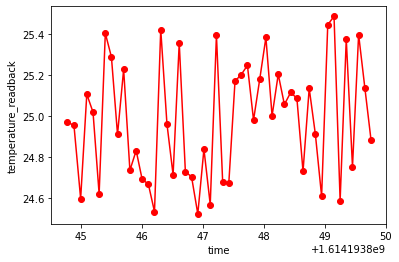

In [7]:
dataset["temperature_readback"].plot(marker="o", color="red")